In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install torch torchvision numpy matplotlib


Note: you may need to restart the kernel to use updated packages.


In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset
dataset = ImageFolder(root='/kaggle/input/cat-dataset', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)


In [14]:
import torch.nn as nn

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)


In [15]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = Generator().to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))


Epoch [1/10] Loss D: 0.4029495418071747, Loss G: 3.5670166015625
Epoch [2/10] Loss D: 0.3901072293519974, Loss G: 3.6741280555725098
Epoch [3/10] Loss D: 0.7857390493154526, Loss G: 1.4614052772521973
Epoch [4/10] Loss D: 0.35681281238794327, Loss G: 3.0743532180786133
Epoch [5/10] Loss D: 0.9891201667487621, Loss G: 7.011265277862549
Epoch [6/10] Loss D: 1.2505002915859222, Loss G: 7.289636611938477
Epoch [7/10] Loss D: 0.7296675592660904, Loss G: 4.545006275177002
Epoch [8/10] Loss D: 0.33193379640579224, Loss G: 3.141573429107666
Epoch [9/10] Loss D: 0.37359727919101715, Loss G: 3.8772592544555664
Epoch [10/10] Loss D: 0.8122651129961014, Loss G: 1.4834564924240112


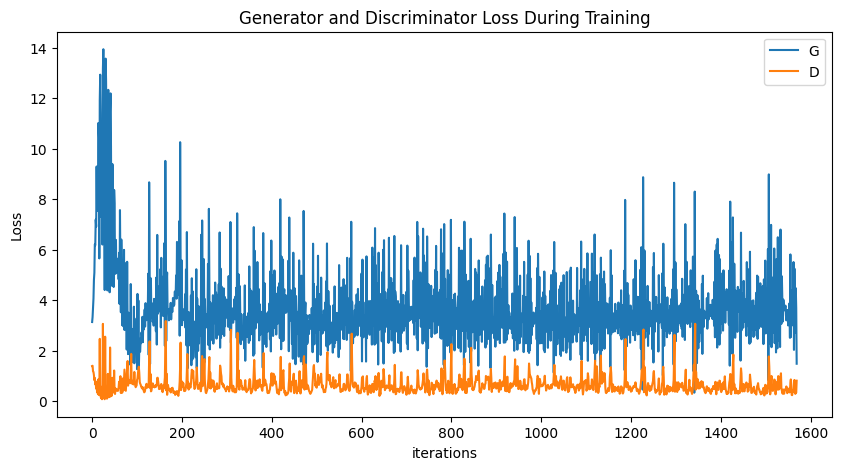

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Training Loop
num_epochs = 10
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        labels = torch.full((batch_size,), 1, dtype=torch.float, device=device)
        output = netD(real_images)
        errD_real = criterion(output, labels)
        errD_real.backward()

        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = netG(noise)
        labels.fill_(0)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, labels)
        errD_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        labels.fill_(1)
        output = netD(fake_images)
        errG = criterion(output, labels)
        errG.backward()
        optimizerG.step()

        # Print and save losses
        G_losses.append(errG.item())
        D_losses.append(errD_real.item() + errD_fake.item())

    print(f'Epoch [{epoch+1}/{num_epochs}] Loss D: {errD_real.item() + errD_fake.item()}, Loss G: {errG.item()}')

# Plot training losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


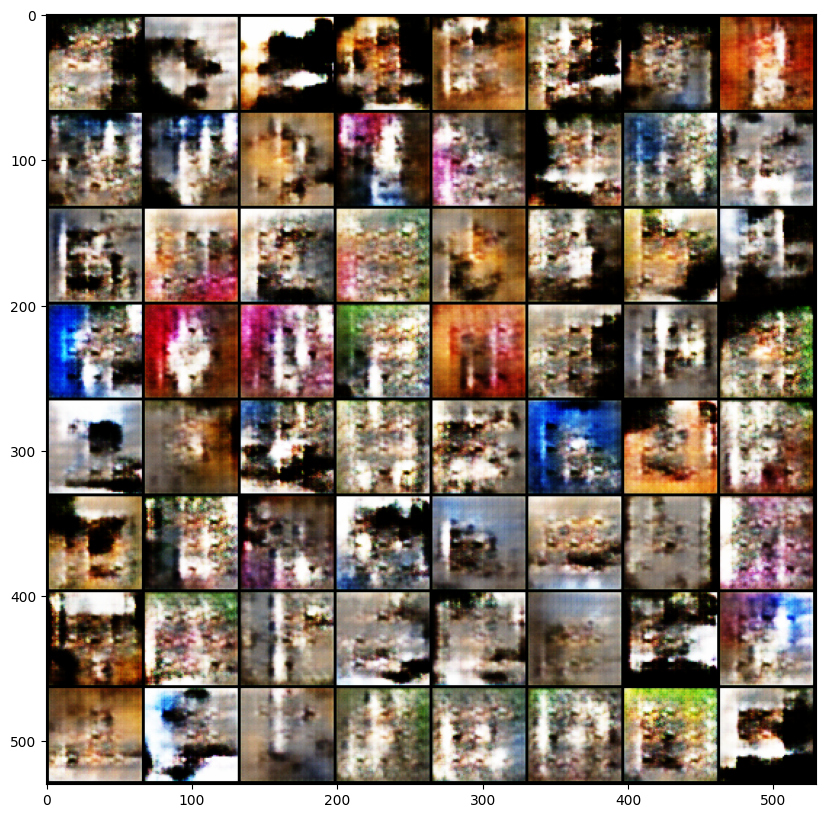

In [18]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

# Generate some images
netG.eval()
with torch.no_grad():
    noise = torch.randn(64, 100, 1, 1, device=device)
    fake_images = netG(noise).detach().cpu()

# Visualize the generated images
grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()
